# Intervention


In [7]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

In [19]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("mps")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


### 1) Get activations


prompt 0
layer 0: [(0.0002, 'positive'), (0.0001, 'excellent'), (0.0, 'awful'), (0.0001, 'negative'), (0.0001, 'awesome')]
layer 1: [(0.0003, 'positive'), (0.0001, 'excellent'), (0.0, 'awful'), (0.0001, 'negative'), (0.0001, 'awesome')]
layer 2: [(0.0005, 'positive'), (0.0002, 'excellent'), (0.0, 'awful'), (0.0002, 'negative'), (0.0001, 'awesome')]
layer 3: [(0.0019, 'positive'), (0.0002, 'excellent'), (0.0, 'awful'), (0.0004, 'negative'), (0.0001, 'awesome')]
layer 4: [(0.0036, 'positive'), (0.0002, 'excellent'), (0.0, 'awful'), (0.0006, 'negative'), (0.0001, 'awesome')]
layer 5: [(0.0057, 'positive'), (0.0003, 'excellent'), (0.0, 'awful'), (0.0011, 'negative'), (0.0001, 'awesome')]
layer 6: [(0.04, 'positive'), (0.0002, 'excellent'), (0.0, 'awful'), (0.01, 'negative'), (0.0001, 'awesome')]
layer 7: [(0.0476, 'positive'), (0.0003, 'excellent'), (0.0, 'awful'), (0.003, 'negative'), (0.0001, 'awesome')]
layer 8: [(0.0238, 'positive'), (0.0003, 'excellent'), (0.0, 'awful'), (0.0035, 'ne

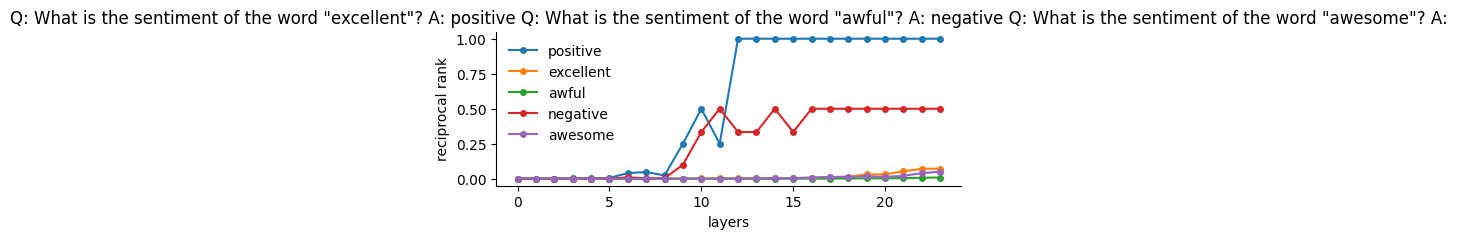

In [28]:
args = [("excellent","positive"), ("awful","negative"), ("awesome","positive")]
prompts = [f'Q: What is the sentiment of the word "{args[0][0]}"? A: {args[0][1]} Q: What is the sentiment of the word "{args[1][0]}"? A: {args[1][1]} Q: What is the sentiment of the word "{args[2][0]}"? A:']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)


token_candidates = list(set(itertools.chain(*args)))

tok_idx = scoring.token_select(tokens, model)
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['ĠIt', 'ĠAwesome', 'ĠI']
extracting blocks.0.hook_resid_post
extracting blocks.1.hook_resid_post
extracting blocks.2.hook_resid_post
extracting blocks.3.hook_resid_post
extracting blocks.4.hook_resid_post
extracting blocks.5.hook_resid_post
extracting blocks.6.hook_resid_post
extracting blocks.7.hook_resid_post
extracting blocks.8.hook_resid_post
extracting blocks.9.hook_resid_post
extracting blocks.10.hook_resid_post
extracting blocks.11.hook_resid_post
extracting blocks.12.hook_resid_post
extracting blocks.13.hook_resid_post
extracting blocks.14.hook_resid_post
extracting blocks.15.hook_resid_post
extracting blocks.16.hook_resid_post
extracting blocks.17.hook_resid_post
patching blocks.18.hook_mlp_out
extracting blocks.18.hook_resid_post
patching blocks.19.hook_mlp_out
extracting blocks.19.hook_resid_post
patching blocks.20.hook_mlp_out
extracting blocks.20.hook_resid_post
patching blocks.21.hook_mlp_out
extracting blocks.21.hook_resid_post
patching blocks.22.hook_mlp_out
extracting

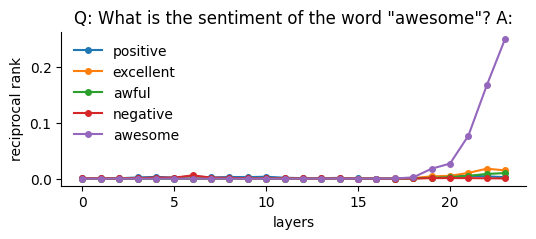

In [35]:
new_prompts = [f'Q: What is the sentiment of the word "{args[2][0]}"? A:']
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

extract_l = [18, 40]
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, extract_tok_idx=-1, l_start_end=extract_l)
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = token_candidates

## scoring
tok_idx = scoring.token_select(new_tokens, model)
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
